# Libraries

In [1]:
import pandas as pd
import numpy as np

# Constants

In [2]:
SEED = 42

# Load the data

In [3]:
train = pd.read_csv('../input/train.csv')

In [4]:
test = pd.read_csv('../input/test.csv')

# Analysis

In [5]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.tail()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
4204,8410,aj,h,as,f,d,aa,j,e,0,...,0,0,0,0,0,0,0,0,0,0
4205,8411,t,aa,ai,d,d,aa,j,y,0,...,0,1,0,0,0,0,0,0,0,0
4206,8413,y,v,as,f,d,aa,d,w,0,...,0,0,0,0,0,0,0,0,0,0
4207,8414,ak,v,as,a,d,aa,c,q,0,...,0,0,1,0,0,0,0,0,0,0
4208,8416,t,aa,ai,c,d,aa,g,r,0,...,1,0,0,0,0,0,0,0,0,0


In [7]:
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (4209, 378)
Test shape: (4209, 377)


# Feature encoding

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
for column_name in train.columns[2:]:
    label_encoder = LabelEncoder() 
    
    train_column_values = list(train[column_name].values)
    test_column_values = list(test[column_name].values)
    
    label_encoder.fit(train_column_values + test_column_values)
    
    train[column_name] = label_encoder.transform(train_column_values)
    test[column_name] = label_encoder.transform(test_column_values)

In [10]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,37,23,20,0,3,27,9,14,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,37,21,22,4,3,31,11,14,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,24,24,38,2,3,30,9,23,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,24,21,38,5,3,30,11,4,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,24,23,38,5,3,14,3,13,...,0,0,0,0,0,0,0,0,0,0


# Feature engineering

In [11]:
from sklearn.decomposition import PCA, FastICA, LatentDirichletAllocation, RandomizedPCA, DictionaryLearning
from sklearn.decomposition import TruncatedSVD, ProjectedGradientNMF, FactorAnalysis, IncrementalPCA

from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

In [12]:
COMPONENT_NUM = 90

decompositions = [
    TruncatedSVD(n_components=COMPONENT_NUM, random_state=SEED),
    PCA(n_components=COMPONENT_NUM, random_state=SEED),
    FastICA(n_components=COMPONENT_NUM, random_state=SEED),
    FactorAnalysis(n_components=COMPONENT_NUM, random_state=SEED),
    GaussianRandomProjection(n_components=COMPONENT_NUM, eps=0.1, random_state=SEED),
    SparseRandomProjection(n_components=COMPONENT_NUM, dense_output=True, random_state=SEED),
    
    #DictionaryLearning(n_components=COMPONENT_NUM, n_jobs=8, random_state=SEED),
    #LatentDirichletAllocation(n_topics=COMPONENT_NUM, random_state=SEED)
    #ProjectedGradientNMF(n_components=COMPONENT_NUM, random_state=SEED),
]

decomp_names = ['tSVD', 'PCA', 'ICA', 'GRP', 'SRP']

train_decomp_features = [decompositor.fit_transform(train.drop(["y"], axis=1)) for decompositor in decompositions]
test_decomp_features = [decompositor.transform(test) for decompositor in decompositions]

In [13]:
decomposition_features = []

for i in range(1, COMPONENT_NUM + 1):
    
    for feature_name, train_decomp_feature, test_decomp_feature in zip(
        decomp_names,
        train_decomp_features,
        test_decomp_features
    ):
    
        enumerated_feature_name = feature_name + '_' + str(i)
        train[enumerated_feature_name] = train_decomp_feature[:,i-1]
        test[enumerated_feature_name] = test_decomp_feature[:,i-1]
        
        decomposition_features.append(enumerated_feature_name)

In [14]:
train.head(2)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,tSVD_89,PCA_89,ICA_89,GRP_89,SRP_89,tSVD_90,PCA_90,ICA_90,GRP_90,SRP_90
0,0,130.81,37,23,20,0,3,27,9,14,...,-0.142793,0.154351,0.026768,1.422575e-08,1.991487,0.102304,0.277541,0.031622,-1.265120e-09,-3.707266
1,6,88.53,37,21,22,4,3,31,11,14,...,-0.052571,-0.277157,0.004606,4.757990e-01,-0.543723,-0.279242,-0.154363,-0.015954,1.420850e+00,-3.486997


In [ ]:
#These features overfit (meh)

# categorical_features_num = 9
# for i in range(categorical_features_num):
#     if i == 7:
#         continue
    
#     new_feature_name = 'mean_x' + str(i)
#     select_feature_name = 'X' + str(i)
    
#     mean_feature = train[[select_feature_name, 'y']].groupby([select_feature_name], as_index=False).median()
#     mean_feature.columns = [select_feature_name, new_feature_name]
    
#     train = pd.merge(train, mean_feature, on=select_feature_name, how='outer')
    
#     test = pd.merge(test, mean_feature, on=select_feature_name, how='left')
#     test[new_feature_name].fillna(test[new_feature_name].dropna().median(), inplace=True)

In [17]:
train.head(3)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,tSVD_89,PCA_89,ICA_89,GRP_89,SRP_89,tSVD_90,PCA_90,ICA_90,GRP_90,SRP_90
0,0,130.81,37,23,20,0,3,27,9,14,...,-0.142793,0.154351,0.026768,1.422575e-08,1.991487,0.102304,0.277541,0.031622,-1.265120e-09,-3.707266
1,6,88.53,37,21,22,4,3,31,11,14,...,-0.052571,-0.277157,0.004606,4.757990e-01,-0.543723,-0.279242,-0.154363,-0.015954,1.420850e+00,-3.486997
2,7,76.26,24,24,38,2,3,30,9,23,...,0.677451,-0.200105,0.010373,-1.676154e+00,3.553038,-0.254074,0.147111,0.030815,-1.120679e+00,-1.493414


In [18]:
import itertools

In [19]:
important_features = ['X0', 'X314','X5', 'X8']

for feature_combination in itertools.combinations(important_features, 2):
    feature_name = '_mul_'.join(feature_combination)
    
    train[feature_name] = train[feature_combination[0]] * train[feature_combination[1]]
    test[feature_name] = train[feature_combination[0]] * train[feature_combination[1]]

In [20]:
train.head(2)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,PCA_90,ICA_90,GRP_90,SRP_90,X0_mul_X314,X0_mul_X5,X0_mul_X8,X314_mul_X5,X314_mul_X8,X5_mul_X8
0,0,130.81,37,23,20,0,3,27,9,14,...,0.277541,0.031622,-1.265120e-09,-3.707266,0,999,518,0,0,378
1,6,88.53,37,21,22,4,3,31,11,14,...,-0.154363,-0.015954,1.420850e+00,-3.486997,0,1147,518,0,0,434


In [21]:
transformations = {
    'abs':lambda x: abs(x),
    'squared':lambda x: x**2,
    'log':lambda x: np.log(x) if x > 1 else 0,
    'sqrt':lambda x: np.sqrt(x) if x > 0 else 0
}

for important_feature in important_features:
    for name, func in transformations.items():
        
        feature_name = important_feature + '_' + name
        train[feature_name] = train[important_feature].apply(func)
        test[feature_name] = train[important_feature].apply(func)

In [22]:
train.head(2)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X314_sqrt,X314_squared,X5_abs,X5_log,X5_sqrt,X5_squared,X8_abs,X8_log,X8_sqrt,X8_squared
0,0,130.81,37,23,20,0,3,27,9,14,...,0.0,0,27,3.295837,5.196152,729,14,2.639057,3.741657,196
1,6,88.53,37,21,22,4,3,31,11,14,...,0.0,0,31,3.433987,5.567764,961,14,2.639057,3.741657,196


# Target and features

In [15]:
target = 'y'

try:
    features = list(train.columns[2:]) + decomposition_features
except:
    features = list(train.columns[2:])

# Deduplicate features
features = list(set(features))

In [16]:
print(features)

['X2', 'ICA_89', 'ICA_84', 'SRP_4', 'X254', 'tSVD_40', 'tSVD_44', 'SRP_44', 'ICA_80', 'X108', 'SRP_40', 'ICA_41', 'GRP_73', 'PCA_51', 'X41', 'GRP_6', 'X200', 'X240', 'tSVD_41', 'GRP_5', 'ICA_25', 'tSVD_89', 'X332', 'X11', 'X267', 'X320', 'X48', 'X344', 'tSVD_27', 'tSVD_58', 'PCA_85', 'PCA_80', 'X304', 'tSVD_26', 'X87', 'X253', 'ICA_51', 'X375', 'GRP_7', 'tSVD_11', 'X123', 'SRP_63', 'ICA_81', 'GRP_10', 'X110', 'tSVD_63', 'X92', 'X369', 'tSVD_10', 'X27', 'ICA_65', 'X327', 'ICA_32', 'GRP_33', 'GRP_83', 'X29', 'GRP_50', 'ICA_16', 'X137', 'X277', 'GRP_51', 'GRP_67', 'PCA_71', 'X201', 'tSVD_12', 'GRP_70', 'tSVD_65', 'PCA_41', 'GRP_77', 'X179', 'X17', 'X221', 'X10', 'X232', 'X122', 'GRP_15', 'ICA_77', 'X245', 'PCA_15', 'PCA_52', 'X286', 'X340', 'tSVD_31', 'SRP_71', 'X30', 'tSVD_47', 'GRP_14', 'PCA_61', 'tSVD_85', 'X80', 'SRP_26', 'X33', 'X5', 'X102', 'GRP_30', 'PCA_53', 'X324', 'X69', 'X358', 'X365', 'X233', 'SRP_52', 'tSVD_72', 'ICA_44', 'PCA_40', 'X309', 'tSVD_70', 'X235', 'tSVD_54', 'ICA_9

# Outlier detection and removal

In [23]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

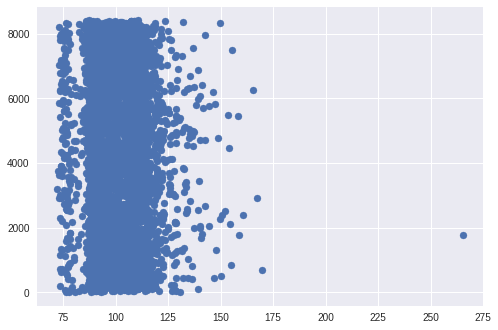

In [24]:
plt.scatter(train[target], train['ID'])
plt.show()

In [25]:
train = train[train.y < 120]

# Preprocessing

In [26]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from multiprocessing import Pool

import keras
from keras import backend as K
K.set_image_dim_ordering('tf')

/home/weenkus/anaconda3/envs/kaggle/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [27]:
X_train = train[features]
X_test = test[features]
y_train = train[target]

In [28]:
X_train.head()

,X2,ICA_89,ICA_84,SRP_4,X254,tSVD_40,tSVD_44,SRP_44,ICA_80,X108,...,X76,X203,PCA_47,ICA_39,tSVD_84,PCA_6,X63,tSVD_21,GRP_53,X163
1,22,0.004606,0.001970,7.180241,0,-0.157008,0.012006,3.836379,0.001295,0,...,0,0,0.129909,-0.000570,0.200648,-25.188492,0,-1.163378,0.014294,0
2,38,0.010373,0.007173,4.378092,0,0.054293,0.045238,-0.093274,0.002268,0,...,1,0,0.230344,0.009157,-0.132731,-23.057021,0,0.372820,-0.307887,1
3,38,-0.009223,0.003205,3.708562,0,0.369901,0.028934,-1.550194,0.009189,1,...,1,0,0.258134,-0.004564,0.056189,-25.484677,0,-0.009335,-0.125895,0
4,38,-0.005365,0.000998,6.109581,0,-0.121014,-0.060258,2.379016,0.007880,1,...,1,0,0.305924,0.005504,-0.119463,-8.548080,0,-0.048346,0.014739,0
5,29,0.002142,0.001954,10.110897,0,0.017224,-0.064437,2.277382,0.029361,0,...,0,0,-0.199057,-0.011003,0.043469,-6.460379,0,0.350903,-0.020112,0


In [29]:
print(X_train.shape, X_test.shape)

(3989, 826) (4209, 826)


In [30]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train.as_matrix(), y_train.as_matrix(), test_size=0.1, random_state=SEED
)

In [31]:
# scaler = StandardScaler()

# # train_X = np.nan_to_num(train_X)
# # val_X = np.nan_to_num(val_X)
# # test_X = np.nan_to_num(test_X)

# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# Model

In [32]:
from sklearn.metrics import log_loss, auc, f1_score, r2_score, mean_squared_error

from keras.layers.advanced_activations import PReLU
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU

from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.layers import Merge, Conv1D, merge

from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, BatchNormalization, TimeDistributed, Input
from keras.layers import MaxPooling1D, Lambda, Convolution1D, Flatten, SpatialDropout1D
from keras_tqdm import TQDMNotebookCallback
from keras.layers.merge import Concatenate

from keras.optimizers import Adam, RMSprop, Adamax, Adagrad, Nadam, SGD
from keras.activations import elu, relu, tanh, sigmoid
from keras.constraints import maxnorm

from keras.models import load_model, Model
from keras.wrappers.scikit_learn import KerasRegressor

from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import random
import xgboost as xgb

In [33]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [34]:
# def get_model(seed):
#     model = XGBRegressor(
#         n_estimators=1580,
#         learning_rate=0.0031,
#         max_depth=2,
#         colsample_bytree=0.676,
#         colsample_bylevel=0.87,
#         reg_alpha=0.15,
#         reg_lambda=1.7,
#         gamma=0.77,
#         base_score=np.mean(y_train),
#         seed=seed,
#         max_delta_step=22.0,
#     )
    
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test).ravel()

# ensemble = [get_model(random.randint(0, 10000)) for i in range(20)]

In [ ]:
# model = make_pipeline(
#     PolynomialFeatures(2),
#     classifier
# )

# params = {
#     'n_estimators':[1500],
#     'learning_rate':[0.1]
# }

# model = GridSearchCV(
#     XGBRegressor(
#         n_estimators=1500,
#         learning_rate=0.1,
#         min_child_weight=1.5,
#         max_depth=1,
#         gamma=0.0,
#         colsample_bytree=0.85,
#         subsample=1.0,
#         reg_alpha=96,
#         reg_lambda=5e-06,
#         seed=SEED
#     ),
#     params,
#     cv=5,
#     n_jobs=1,
#     verbose=3,
#     scoring='r2'
# )
#print(model.best_params_, model.best_score_)

# model = XGBRegressor(
#         n_estimators=1500,
#         learning_rate=0.1,
#         min_child_weight=1.5,
#         max_depth=1,
#         gamma=0.0,
#         colsample_bytree=0.85,
#         subsample=1.0,
#         reg_alpha=96,
#         reg_lambda=5e-06,
#         seed=SEED
#     )

# model = XGBRegressor(
#     n_estimators=1580,
#     learning_rate=0.0031,
#     max_depth=2,
#     colsample_bytree=0.676,
#     colsample_bylevel=0.87,
#     reg_alpha=0.15,
#     reg_lambda=1.7,
#     gamma=0.77,
#     base_score=np.mean(y_train),
#     seed=SEED,
#     max_delta_step=22.0,
# )

params = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

model = GridSearchCV(
            XGBRegressor(
            n_estimators=500,
            learning_rate=0.005,
            max_depth=3,
            min_child_weight=5,
            gamma=0,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_alpha=0,
            base_score=np.mean(y_train),
            seed=SEED,
        ),
        params,
        cv=3,
        n_jobs=1,
        verbose=3,
        scoring='r2'
)

# model=XGBRegressor(
#     n_estimators=500,
#     learning_rate=0.005,
#     max_depth=3,
#     min_child_weight=5,
#     gamma=0,
#     subsample=0.9,
#     colsample_bytree=0.9,
#     base_score=np.mean(y_train),
#     seed=SEED,
# )

val_set = [(X_train, y_train), (X_val, y_val)]
#model.fit(X_train, y_train, eval_set=val_set, eval_metric="rmse", early_stopping_rounds=50)
model.fit(X_train, y_train)
print(model.best_params_, model.best_score_)

y_pred = model.predict(X_val)
print('R2:', r2_score(y_val, y_pred))
print('MSE:', mean_squared_error(y_val, y_pred))

In [35]:
model = XGBRegressor(
    n_estimators=1580,
    learning_rate=0.0031,
    max_depth=2,
    colsample_bytree=0.676,
    colsample_bylevel=0.87,
    reg_alpha=0.15,
    reg_lambda=1.7,
    gamma=0.77,
    base_score=np.mean(y_train),
    seed=SEED,
    max_delta_step=22.0)

# XGBRegressor(
#             n_estimators=500,
#             learning_rate=0.005,
#             max_depth=3,
#             min_child_weight=5,
#             gamma=0,
#             subsample=0.85,
#             colsample_bytree=0.85,
#             reg_alpha=0,
#             base_score=np.mean(y_train),
#             seed=SEED,
#         )

model.fit(X_train, y_train)

# < 200
# R2: 0.553275141921
# MSE: 66.4260182089

# < 120
# R2: 0.717349259144
# MSE: 27.6059208528

y_pred = model.predict(X_val)
print('R2:', r2_score(y_val, y_pred))
print('MSE:', mean_squared_error(y_val, y_pred))

R2: 0.717349259144
MSE: 27.6059208528


In [ ]:
# y_mean = np.mean(y_train)

# xgb_params = {
#     'n_trees': 500, 
#     'eta': 0.005,
#     'max_depth': 4,
#     'subsample': 0.95,
#     'objective': 'reg:linear',
#     'eval_metric': 'rmse',
#     'base_score': y_mean, # base prediction = mean(target)
#     'silent': 1
# }

# # form DMatrices for Xgboost training
# dtrain = xgb.DMatrix(X_train, y_train)
# dtest = xgb.DMatrix(X_test)

# # xgboost, cross-validation
# cv_result = xgb.cv(xgb_params, 
#                    dtrain, 
#                    num_boost_round=700, # increase to have better results (~700)
#                    early_stopping_rounds=50,
#                    verbose_eval=50, 
#                    #show_stdv=False
#                   )

# num_boost_rounds = len(cv_result)
# print(num_boost_rounds)

# # train model
# model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

In [ ]:
# now fixed, correct calculation
print(r2_score(dtrain.get_label(), model.predict(dtrain)))

In [ ]:
# CV-5-R2: 0.545503957703
# R2: 0.624897831936
# MSE: 53.8534300079

# R2: 0.638541670147
# MSE: 51.894583729

In [ ]:
import tensorflow as tf

# def selu(x):
#     alpha = 1.6732632423543772848170429916717
#     scale = 1.0507009873554804934193349852946
#     return K.elu(x, alpha) * scale

# -*- coding: utf-8 -*-
'''
Tensorflow Implementation of the Scaled ELU function and Dropout
'''

from __future__ import absolute_import, division, print_function
import numbers
from tensorflow.contrib import layers
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.layers import utils


# (4) use this dropout
def dropout_selu(x, rate=0.25, alpha= -1.7580993408473766, fixedPointMean=0.0, fixedPointVar=1.0, 
                 noise_shape=None, seed=None, name=None, training=False):
    """Dropout to a value with rescaling."""

    def dropout_selu_impl(x, rate, alpha, noise_shape, seed, name):
        keep_prob = 1.0 - rate
        x = ops.convert_to_tensor(x, name="x")
        if isinstance(keep_prob, numbers.Real) and not 0 < keep_prob <= 1:
            raise ValueError("keep_prob must be a scalar tensor or a float in the "
                                             "range (0, 1], got %g" % keep_prob)
        keep_prob = ops.convert_to_tensor(keep_prob, dtype=x.dtype, name="keep_prob")
        keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

        alpha = ops.convert_to_tensor(alpha, dtype=x.dtype, name="alpha")
        keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

        if tensor_util.constant_value(keep_prob) == 1:
            return x

        noise_shape = noise_shape if noise_shape is not None else array_ops.shape(x)
        random_tensor = keep_prob
        random_tensor += random_ops.random_uniform(noise_shape, seed=seed, dtype=x.dtype)
        binary_tensor = math_ops.floor(random_tensor)
        ret = x * binary_tensor + alpha * (1-binary_tensor)

        a = tf.sqrt(fixedPointVar / (keep_prob *((1-keep_prob) * tf.pow(alpha-fixedPointMean,2) + fixedPointVar)))

        b = fixedPointMean - a * (keep_prob * fixedPointMean + (1 - keep_prob) * alpha)
        ret = a * ret + b
        ret.set_shape(x.get_shape())
        return ret

    with ops.name_scope(name, "dropout", [x]) as name:
        return utils.smart_cond(training,
            lambda: dropout_selu_impl(x, rate, alpha, noise_shape, seed, name),
            lambda: array_ops.identity(x))

In [ ]:
import tensorflow as tf

def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * tf.where(x >= 0.0, x, alpha * tf.nn.elu(x))

In [ ]:
model = Sequential()

model.add(Dense(512, input_dim=X_train.shape[1],
                kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN')))
model.add(Activation(selu))
model.add(BatchNormalization())


for i in range(10):
    model.add(Dense(
        512,
        kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN'))
    )
    model.add(Activation(selu))
    model.add(BatchNormalization())
    model.add(Dropout(0.21))

#variance_scaling_initializer( factor=1.0, mode='FAN_IN') 
model.add(Dense(1, activation='linear'))   

In [ ]:
model = Sequential()

model.add(Dense(512, input_dim=X_train.shape[1]))
model.add(Activation(relu))
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(Dense(512))
model.add(Activation(relu))
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(Dense(512))
model.add(Activation(relu))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(512))
model.add(Activation(relu))
model.add(BatchNormalization())
model.add(Dropout(0.45))

model.add(Dense(512))
model.add(Activation(relu))
model.add(BatchNormalization())

model.add(Dense(1, activation='linear'))   

In [ ]:
model.compile(
    loss='mean_squared_error',
    optimizer=Adam(0.00004, clipnorm=3.5),
    metrics=[R2]
)

model.fit(
    X_train, y_train,
    batch_size=512,
    epochs=25,
    validation_data = (X_val, y_val),
    verbose=0,
    callbacks=[TQDMNotebookCallback()] 
)

In [ ]:
## model = Sequential()

# model.add(Dense(512, input_dim=train_X.shape[1]))
# model.add(Activation(elu))
# model.add(BatchNormalization())

# dropout_rate = 0.001
# neuron_decay = 0.99
# base_neurons = 300

# for i in range(50):
#     base_neurons = int(base_neurons * neuron_decay) 
    
#     model.add(Dense(base_neurons))
#     model.add(Activation(elu))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_rate * i))
    
#     print('Neurons:', base_neurons, ' dropout:', dropout_rate)
    
    
    
# model.add(Dense(1))

# Submission

In [36]:
try:
    X_test = X_test.as_matrix()
except Exception:
    pass

In [37]:
try:
    predictions = model.predict(X_test).ravel()
except:
    predictions = model.predict(dtest)

In [38]:
model_name = 'xgb_MSE_27_605_R2_7173'
#model.save('../models/' + model_name + '.h5')

output = pd.DataFrame({'id': test['ID'].copy().values, 'y': predictions})
output.to_csv('../submissions/submission_' + model_name + '.csv', index=False)